In [1]:
import numpy as np
import pandas as pd
import loadData
import monteCarloClass
import time

In [2]:
data, dataName = loadData.loadData("mt_all.csv")
intensityVariable = "deltaDurS"
sensoryVar = "audNoise"
standardVar = "standardDur"
conflictVar = "conflictDur"
#s
visualStandardVar = "unbiasedVisualStandardDur"
visualTestVar = "unbiasedVisualTestDur"
audioStandardVar = "standardDur"
audioTestVar = "testDurS"
# Instantiate the Monte Carlo class
mc_fitter = monteCarloClass.OmerMonteCarlo(data)
print("Visual test duration range:", data["recordedDurVisualTest"].min(), "to", data["recordedDurVisualTest"].max())
# fit parameters
mc_fitter.nStart = 1 # Number of random starts for optimization
mc_fitter.nSimul = 500
mc_fitter.optimizationMethod= "bads"  # Use BADS for optimization
mc_fitter.modelName = "lognorm"  # Set measurement distribution to Gaussian
mc_fitter.integrationMethod = "analytical"  # Use numerical integration instead of analytical
mc_fitter.freeP_c = False  # Allow different prior widths for conflict conditions
mc_fitter.sharedLambda = False  # Use separate lapse rates for each condition
mc_fitter.dataName = dataName



 Total trials before cleaning
: 2156
uniqueSensory: [1.2 0.1] 
 uniqueStandard: [0.5] 
 uniqueConflict: [np.float64(-0.25), np.float64(-0.17), np.float64(-0.08), np.float64(0.0), np.float64(0.08), np.float64(0.17), np.float64(0.25)]
total trials after cleaning: 2156
Visual test duration range: 0.1072 to 1.0763


In [3]:
# read back the saved file to verify
import os
import json
import loadResults
try:
    res=loadResults.loadFitResults(mc_fitter,dataName, modelName=mc_fitter.modelName)
    res_with_new_lines = json.dumps(res, indent=4)
    print("Loaded saved fit results:\n")
    print(res_with_new_lines)
    #print(f"Loaded saved fit results: {res}")
    mc_fitter.modelFit= res['fittedParams']
    mc_fitter.logLikelihood= res['logLikelihood']
    mc_fitter.aic= res['AIC']
    mc_fitter.bic= res['BIC']
    mc_fitter.nDataPoints= res['n_conditions']
except:
    print("No saved fit results found, proceeding to fit the model.")
    user_input = input("Do you want to proceed with model fitting? (yes/no): ").strip().lower()
    if user_input != 'yes':
        print("Model fitting skipped.")
        
    timeStart = time.time()
    print(f"\nFitting Causal Inference Model for {dataName} with {len(mc_fitter.groupedData)} unique conditions")
    fittedParams = mc_fitter.fitCausalInferenceMonteCarlo(mc_fitter.groupedData)
    print(f"\nFitted parameters for {dataName}: {fittedParams}")
    print(f"Time taken to fit: {time.time() - timeStart:.2f} seconds")
    mc_fitter.modelFit= fittedParams
    mc_fitter.logLikelihood= -mc_fitter.nLLMonteCarloCausal(fittedParams, mc_fitter.groupedData)    
    
    #save the fit results
    import fitSaver
    fitSaver.saveFitResultsSingle(mc_fitter, mc_fitter.modelFit, dataName)

Looking for saved fit: mt_all with model lognorm_LapseFree_sharedPrior
Loaded saved fit results:

{
    "participantID": "mt",
    "modelType": "lognorm_LapseFree_sharedPrior",
    "fittedParams": [
        0.032721803495229546,
        0.15576154849977908,
        0.3718890945007365,
        0.7982787610074273,
        0.46007481075666873,
        0.14598556138063035,
        0.21001085452070584,
        0.5957054038783781,
        2.1428683373655852
    ],
    "AIC": 2209.9903735016615,
    "BIC": 2244.9151703792677,
    "logLikelihood": -1095.9951867508307,
    "n_conditions": 358
}


## Simulate data using fitted parameters

In [4]:
#proceed to simulate and save to {filename}
from loadSimData import loadSimulatedData
mc_fitter.simulatedData=loadSimulatedData(fitter=mc_fitter, dataName=mc_fitter.dataName, participantID=dataName.split(".csv")[0], modelType=mc_fitter.modelName)


Loaded saved simulated data from simulated_data/mt/mt_lognorm_LapseFree_sharedPrior_simulated.csv


In [5]:
# so now we have loaded the simulated data, fitted parameters, loglikelihood, aic, bic

In [6]:
# Load psychometric fits for both data and simulated data
import importlib
import psychometricFitLoader as pfl_data
import psychometricFitLoader_simulated as pfl_sim

# Get participant ID
dataID = dataName.split("_")[0]

# Load real data psychometric fit
mc_fitter.dataFit = pfl_data.load_psychometric_fit(dataID)
print(f"✅ Loaded real data psychometric fit for {dataID}")
print(f"   AIC: {mc_fitter.dataFit['AIC']:.2f}, Params: {mc_fitter.dataFit['n_params']}")


✅ Loaded real data psychometric fit for mt
   AIC: 2242.25, Params: 42


In [7]:

mc_fitter.simDataFit=mc_fitter.fitMultipleStartingPoints(mc_fitter.simulatedData,1)

# Plot the fits

Plotting psychometric curves for Monte Carlo model and data...
Noise: 0.1, Conflict: -0.25, Lambda: 0.210, Sigma_a: 0.156, Sigma_v: 0.372, p_c: 0.798
Noise: 0.1, Conflict: -0.17, Lambda: 0.033, Sigma_a: 0.156, Sigma_v: 0.372, p_c: 0.798
Noise: 0.1, Conflict: -0.08, Lambda: 0.146, Sigma_a: 0.156, Sigma_v: 0.372, p_c: 0.798
Noise: 0.1, Conflict: 0.0, Lambda: 0.033, Sigma_a: 0.156, Sigma_v: 0.372, p_c: 0.798
Noise: 0.1, Conflict: 0.08, Lambda: 0.210, Sigma_a: 0.156, Sigma_v: 0.372, p_c: 0.798
Noise: 0.1, Conflict: 0.17, Lambda: 0.146, Sigma_a: 0.156, Sigma_v: 0.372, p_c: 0.798
Noise: 0.1, Conflict: 0.25, Lambda: 0.033, Sigma_a: 0.156, Sigma_v: 0.372, p_c: 0.798
Noise: 1.2, Conflict: -0.25, Lambda: 0.210, Sigma_a: 0.460, Sigma_v: 0.372, p_c: 0.798
Noise: 1.2, Conflict: -0.17, Lambda: 0.033, Sigma_a: 0.460, Sigma_v: 0.372, p_c: 0.798
Noise: 1.2, Conflict: -0.08, Lambda: 0.146, Sigma_a: 0.460, Sigma_v: 0.372, p_c: 0.798
Noise: 1.2, Conflict: 0.0, Lambda: 0.033, Sigma_a: 0.460, Sigma_v: 0.372

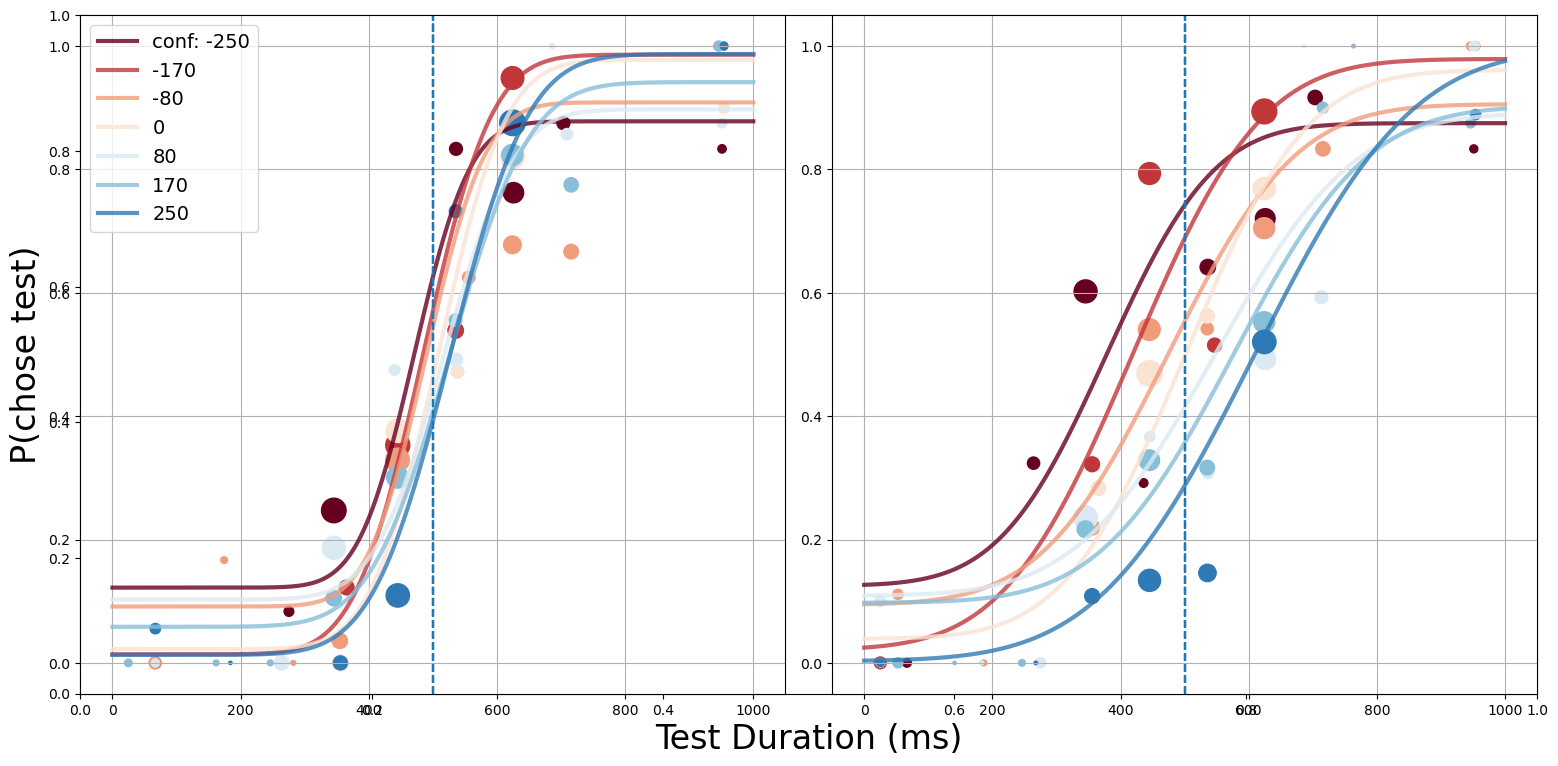

In [9]:
from matplotlib import pyplot as plt
import seaborn as sns
def bin_and_plot(data, bin_method='cut', bins=10, bin_range=None, plot=True,color="blue",binVar='delta_dur_percents'):
    if bin_method == 'cut':
        data['bin'] = pd.cut(data[binVar], bins=bins, labels=False, include_lowest=True, retbins=False)
    elif bin_method == 'manual':
        data['bin'] = np.digitize(data[binVar], bins=bin_range) - 1
    
    grouped = data.groupby('bin').agg(
        x_mean=(binVar, 'mean'),
        y_mean=('p_choose_test', 'mean'),
        total_resp=('total_responses', 'sum')
    )

    if plot:
        plt.scatter(grouped['x_mean'], grouped['y_mean'], s=grouped['total_resp']/data['total_responses'].sum()*900, color=color)

def plotPsychometrics_MC_Data(self):
    "use self to get the  required stuff"
    print("Plotting psychometric curves for Monte Carlo model and data...")
    pltTitle = self.dataName + " "+ self.modelName+" Model Fit"
    plt.figure(figsize=(16, 8))
    #plt.title(f"{pltTitle} AV,A duration comparison", fontsize=26)
    plt.xlabel("Test Duration (ms)", fontsize=24)
    plt.ylabel("P(chose test)",fontsize=24)

    for i, standardLevel in enumerate(self.uniqueStandard):
        for j, audioNoiseLevel in enumerate(sorted(self.uniqueSensory)):
            for k, conflictLevel in enumerate(self.uniqueConflict):
                plt.subplot(1, 2, j + 1)
                x = np.linspace(-0.6, 0.6, 1000)
                color = sns.color_palette("RdBu", as_cmap=True)(k / len(self.uniqueConflict))
                

                paramsSimFit=self.getParams(self.simDataFit.x, conflictLevel,audioNoiseLevel)
                # Plot data fit: plot psychometric curve from fitted data
                ySimSigmoid=self.psychometric_function(x, paramsSimFit[0],paramsSimFit[1],paramsSimFit[2])

                
                xPlot=np.linspace(0,1000,1000)
                if k==0:
                    plt.plot(xPlot, ySimSigmoid, color=color, linestyle='-', label=f"conf: {int(conflictLevel*1000)}", linewidth=3, alpha=0.8)
                else:
                    plt.plot(xPlot, ySimSigmoid, color=color, linestyle='-', linewidth=3, alpha=0.8,label=f"{int(conflictLevel*1000)}")
                plt.axvline(500, linestyle='--')


                "plot the monte carlo"
                lambda_, sigma_av_a, sigma_av_v, p_c ,tmin,tmax= self.getParamsCausal(self.modelFit, audioNoiseLevel, conflictLevel)

        
                #plt.axvline(x=0, color='gray', linestyle='--')
                #plt.axhline(y=0.5, color='gray', linestyle='--')
                #plt.xlabel(f"({self.intensityVar}) Test(stair-a)-Standard(a) Duration Difference Ratio(%)")
                #plt.xlabel("Test Duration (ms)", fontsize=24)
                #plt.title(f"{pltTitle} AV,A Duration Comp. Noise: {audioNoiseLevel}", fontsize=26)
                if j==0:
                    plt.legend(fontsize=14, title_fontsize=20)
                plt.grid()


                groupedDataSub = self.groupByChooseTest(
                    self.data[(self.data[self.standardVar] == standardLevel) & (self.data[self.sensoryVar] == audioNoiseLevel) & (self.data[self.conflictVar] == conflictLevel)],
                    [self.intensityVar, self.sensoryVar, self.standardVar, self.conflictVar, self.visualStandardVar, self.visualTestVar, self.audioTestVar, "testDurMs"]
                )
                bin_and_plot(groupedDataSub, bin_method='cut', bins=10, plot=True, color=color,binVar='testDurMs')
                #plt.text(0.05, 0.8, fr"$\sigma_a$: {sigma_av_a:.2f}, $\sigma_v$: {sigma_av_v:.2f},", fontsize=12, ha='left', va='top', transform=plt.gca().transAxes)
                plt.tight_layout()
                #plt.grid(True)
                print(f"Noise: {audioNoiseLevel}, Conflict: {conflictLevel}, Lambda: {lambda_:.3f}, Sigma_a: {sigma_av_a:.3f}, Sigma_v: {sigma_av_v:.3f}, p_c: {p_c:.3f}")
                #plt.text(0.15, 0.9, f"P(C=1): {p_c:.2f}", fontsize=12, ha='center', va='bottom', transform=plt.gca().transAxes)
                
    plt.show()

plotPsychometrics_MC_Data(mc_fitter)